In [1]:
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms  # Dodaj import models z torchvision
import matplotlib.pyplot as plt
import copy
import torchvision
import math
from torchvision import models
from torchsummary import summary
import cv2

# Model Klasyfikacji kart

In [2]:
# Definicja klasy CardDetector
class CardDetector(Dataset):
    def __init__(self, root: str, transform=None):
        self.root = root
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.idx_to_class = {}

        label_directories = os.listdir(root)
        
        for i, label in enumerate(label_directories):
            self.idx_to_class[i] = label
            label_dir_path = os.path.join(root, label)
            img_in_dir = os.listdir(label_dir_path)

            self.image_paths.extend([os.path.join(label_dir_path, img_name) for img_name in img_in_dir])
            self.labels.extend([i] * len(img_in_dir))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)
        
        label = self.labels[idx]
        return image, label

In [3]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ResNet oczekuje obrazów o rozmiarze 224x224
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalizacja dla ImageNet
])

In [4]:
dataset_path = r"C:\Users\48517\Desktop\Kurs CV\Projekt\karty\train"
dataset = CardDetector(dataset_path, transform=transform)
print(len(dataset))

dataset_path_valid = r"C:\Users\48517\Desktop\Kurs CV\Projekt\karty\valid"
valid_dataset = CardDetector(dataset_path_valid, transform=transform)

test_path = r"C:\Users\48517\Desktop\Kurs CV\Projekt\karty\test"
test_dataset = CardDetector(test_path, transform=transform)
print(len(test_dataset))


6424
260


In [5]:
batch_size = 32
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset,batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset,batch_size=batch_size, shuffle=True)

In [19]:
num_classes = len(dataset.idx_to_class)  # Liczba klas to liczba folderów

model = models.resnet18(pretrained=True)  # Możesz wybrać inną wersję ResNet, np. resnet34, resnet50
model.fc = nn.Linear(model.fc.in_features, num_classes)  # Zmiana ostatniej warstwy na liczbę klas

In [6]:
class CustomResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, dropout_rate=0.5):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        # Warstwa dopasowująca wymiar (jeśli liczba kanałów się zmienia)
        self.downsample = None
        if in_channels != out_channels:
            self.downsample = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False)
        
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        identity = x  # Skip connection - dla lepszego przepływu gradientu:

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample:
            identity = self.downsample(identity)  # Dopasowanie wymiaru
        
        out += identity  # Skip connection
        out = self.relu(out)
        out = self.dropout(out)

        return out


In [7]:
class FineTunedResNet(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.5):
        super().__init__()
        self.resnet = models.resnet18(pretrained=True)
        
        # Usunięcie ostatnich 3 warstw (AdaptiveAvgPool2d, Linear, ResNet block)
        self.resnet = nn.Sequential(*list(self.resnet.children())[:-3])
        
        # Zamrożenie oryginalnych warstw
        for param in self.resnet.parameters():
            param.requires_grad = False

        # Dodatkowe niestandardowe bloki ResNet
        self.custom_block1 = CustomResNetBlock(256, 64, dropout_rate)
        self.custom_block2 = CustomResNetBlock(64, 32, dropout_rate)
        
        # Warstwy końcowe
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(32, num_classes)

    def forward(self, x):
        x = self.resnet(x)           # Feature extractor (ResNet bez ostatnich 3 warstw)
        x = self.custom_block1(x)    # Niestandardowy blok ResNet
        x = self.custom_block2(x)    # Niestandardowy blok ResNet
        x = self.avgpool(x)          # Pooling
        x = torch.flatten(x, 1)      # Spłaszczenie
        x = self.dropout(x)          # Dropout
        x = self.fc(x)               # Klasyfikacja
        return x

# Tworzenie modelu dla 52 klas
num_classes = 52
model = FineTunedResNet(num_classes=num_classes, dropout_rate=0.5)
model = model.to("cuda" if torch.cuda.is_available() else "cpu")

# Sprawdzenie architektury
print(model)

c:\Users\48517\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\48517\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FineTunedResNet(
  (resnet): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stat

In [11]:
card_order = [
    "AC", "AD", "AH", "AS",  # Asy
    "8C", "8D", "8H", "8S",  # Ósemki
    "5C", "5D", "5H", "5S",  # Piątki
    "4C", "4D", "4H", "4S",  # Czwórki
    "JC", "JD", "JH", "JS",  # Walety
    "KC", "KD", "KH", "KS",  # Króle
    "9C", "9D", "9H", "9S",  # Dziewiątki
    "QC", "QD", "QH", "QS",  # Damy
    "7C", "7D", "7H", "7S",  # Siódemki
    "6C", "6D", "6H", "6S",  # Szóstki
    "10C", "10D", "10H", "10S",  # Dziesiątki
    "3C", "3D", "3H", "3S",  # Trójki
    "2C", "2D", "2H", "2S"   # Dwójki
]


# STEP 1

In [15]:

# ✅ Sprawdzenie dostępności GPU
device = "cuda" if torch.cuda.is_available() else "cpu"

# ✅ Liczba klas
num_classes = 52

# ✅ Tworzenie modelu i wysłanie na GPU
model = FineTunedResNet(num_classes).to(device)

# ✅ Wyświetlenie architektury modelu
summary(model, (3, 224, 224))

# ✅ Funkcja straty (CrossEntropyLoss)
#criterion = nn.CrossEntropyLoss()

# ✅ Wyłączenie weight decay
learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0)

# ✅ Obliczamy oczekiwany loss na starcie
expected_loss = math.log(num_classes)
print(f"Expected initial loss: {expected_loss:.4f}")

# ✅ Tworzymy losowe dane (batch 8 obrazów 224x224)
dummy_inputs = torch.randn(8, 3, 224, 224).to(device)
dummy_labels = torch.randint(0, num_classes, (8,)).to(device)

# ✅ Testujemy loss na starcie
model.eval()
with torch.no_grad():
    outputs = model(dummy_inputs)
    loss = criterion(outputs, dummy_labels)

print(f"Initial loss: {loss.item():.4f}")

# ✅ Sprawdzenie, czy loss ≈ log(52)
if abs(loss.item() - expected_loss) < 0.1:
    print("✅ Sanity check passed! Initial loss is correct.")
else:
    print("❌ Warning: Initial loss is too different from expected.")


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

# STEP 2

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim

# Ustawienia
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()  # Funkcja straty
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0)  # Bez regularizacji

# Wybierz małą próbkę (5 minibatchy)
small_data = []
num_batches = 5
for i, (inputs, labels) in enumerate(dataloader):
    if i >= num_batches:
        break
    small_data.append((inputs.to(device), labels.to(device)))

# Trening
model.train()
num_epochs = 50  # Cel: 100% trafności, więc trenujemy do skutku
for epoch in range(num_epochs):
    total_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in small_data:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

    acc = 100.0 * correct / total
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {total_loss:.4f} - Acc: {acc:.2f}%")

    # Warunek stopu: 100% trafności
    if acc == 100.0:
        print("✅ Model osiągnął 100% dokładności na małej próbce!")
        break


Epoch 1/50 - Loss: 22.2538 - Acc: 11.25%
Epoch 2/50 - Loss: 17.2783 - Acc: 17.50%
Epoch 3/50 - Loss: 14.8526 - Acc: 29.38%
Epoch 4/50 - Loss: 13.5079 - Acc: 30.00%
Epoch 5/50 - Loss: 11.6818 - Acc: 37.50%
Epoch 6/50 - Loss: 11.2494 - Acc: 41.88%
Epoch 7/50 - Loss: 10.9221 - Acc: 45.62%
Epoch 8/50 - Loss: 10.5393 - Acc: 46.88%
Epoch 9/50 - Loss: 9.8186 - Acc: 51.25%
Epoch 10/50 - Loss: 8.8780 - Acc: 58.12%
Epoch 11/50 - Loss: 9.3041 - Acc: 50.00%
Epoch 12/50 - Loss: 8.4219 - Acc: 60.00%
Epoch 13/50 - Loss: 7.8919 - Acc: 61.25%
Epoch 14/50 - Loss: 7.3651 - Acc: 67.50%
Epoch 15/50 - Loss: 7.4531 - Acc: 59.38%
Epoch 16/50 - Loss: 7.0246 - Acc: 66.25%
Epoch 17/50 - Loss: 7.5022 - Acc: 58.75%
Epoch 18/50 - Loss: 6.7659 - Acc: 62.50%
Epoch 19/50 - Loss: 6.9121 - Acc: 62.50%
Epoch 20/50 - Loss: 6.2690 - Acc: 67.50%
Epoch 21/50 - Loss: 6.1661 - Acc: 66.25%
Epoch 22/50 - Loss: 6.1846 - Acc: 65.62%
Epoch 23/50 - Loss: 5.5089 - Acc: 70.62%
Epoch 24/50 - Loss: 6.1399 - Acc: 66.25%
Epoch 25/50 - Los

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim

# Ustawienia
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()

# Testowane wartości learning rate
learning_rates = [1e-1, 1e-2, 1e-3, 1e-4]
best_lr = None
best_loss = float("inf")

# Szukamy najlepszego LR
for lr in learning_rates:
    print(f"\n🔍 Testowanie learning rate: {lr}")

    # Resetujemy model i optymalizator
    model = FineTunedResNet(num_classes=52, dropout_rate=0.5).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)  # Włączamy weight decay

    # Trening przez 100 iteracji
    model.train()
    for epoch in range(5):  # ~100 iteracji (zależnie od batch_size)
        total_loss = 0.0
        for i, (inputs, labels) in enumerate(dataloader):
            if i >= 20:  # Ograniczamy do pierwszych 20 batchy (~100 iteracji)
                break

            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / 20
        print(f"Epoch {epoch+1}: Loss {avg_loss:.4f}")

        # Zapisujemy najlepszy learning rate
        if avg_loss < best_loss:
            best_loss = avg_loss
            best_lr = lr

print(f"\n✅ Najlepszy learning rate: {best_lr}")



🔍 Testowanie learning rate: 0.1
Epoch 1: Loss 4.1692
Epoch 2: Loss 3.8713
Epoch 3: Loss 3.8031
Epoch 4: Loss 3.8116
Epoch 5: Loss 3.7348

🔍 Testowanie learning rate: 0.01
Epoch 1: Loss 3.9167
Epoch 2: Loss 3.6309
Epoch 3: Loss 3.4492
Epoch 4: Loss 3.1611
Epoch 5: Loss 3.0992

🔍 Testowanie learning rate: 0.001
Epoch 1: Loss 3.9162
Epoch 2: Loss 3.8410
Epoch 3: Loss 3.7289
Epoch 4: Loss 3.6674
Epoch 5: Loss 3.5534

🔍 Testowanie learning rate: 0.0001
Epoch 1: Loss 4.0231
Epoch 2: Loss 3.9489
Epoch 3: Loss 3.9229
Epoch 4: Loss 3.9055
Epoch 5: Loss 3.8528

✅ Najlepszy learning rate: 0.01


In [23]:

# Ustawienia
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()  # Funkcja straty
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0)  # Bez regularizacji

# Wybierz małą próbkę (5 minibatchy)
small_data = []
num_batches = 5
for i, (inputs, labels) in enumerate(dataloader):
    if i >= num_batches:
        break
    small_data.append((inputs.to(device), labels.to(device)))

# Trening
model.train()
num_epochs = 50  # Cel: 100% trafności, więc trenujemy do skutku
for epoch in range(num_epochs):
    total_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in small_data:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

    acc = 100.0 * correct / total
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {total_loss:.4f} - Acc: {acc:.2f}%")

    # Warunek stopu: 100% trafności
    if acc == 100.0:
        print("✅ Model osiągnął 100% dokładności na małej próbce!")
        break


Epoch 1/50 - Loss: 20.0412 - Acc: 3.12%
Epoch 2/50 - Loss: 18.5042 - Acc: 7.50%
Epoch 3/50 - Loss: 17.3909 - Acc: 8.75%
Epoch 4/50 - Loss: 16.1043 - Acc: 16.88%
Epoch 5/50 - Loss: 15.5996 - Acc: 14.38%
Epoch 6/50 - Loss: 15.1437 - Acc: 16.88%
Epoch 7/50 - Loss: 13.7519 - Acc: 24.38%
Epoch 8/50 - Loss: 12.9351 - Acc: 25.00%
Epoch 9/50 - Loss: 12.6537 - Acc: 21.25%
Epoch 10/50 - Loss: 11.5866 - Acc: 33.12%
Epoch 11/50 - Loss: 10.3074 - Acc: 34.38%
Epoch 12/50 - Loss: 9.6332 - Acc: 40.62%
Epoch 13/50 - Loss: 8.8647 - Acc: 49.38%
Epoch 14/50 - Loss: 9.0665 - Acc: 42.50%
Epoch 15/50 - Loss: 8.2203 - Acc: 50.00%
Epoch 16/50 - Loss: 8.5864 - Acc: 41.25%
Epoch 17/50 - Loss: 8.4299 - Acc: 46.25%
Epoch 18/50 - Loss: 6.6164 - Acc: 62.50%
Epoch 19/50 - Loss: 6.7879 - Acc: 51.88%
Epoch 20/50 - Loss: 6.5017 - Acc: 60.62%
Epoch 21/50 - Loss: 5.6888 - Acc: 61.25%
Epoch 22/50 - Loss: 5.6785 - Acc: 67.50%
Epoch 23/50 - Loss: 5.4407 - Acc: 60.00%
Epoch 24/50 - Loss: 5.0261 - Acc: 65.62%
Epoch 25/50 - Los

# Step 4

In [24]:
# Testowane wartości weight decay
weight_decays = [1e-4, 1e-5, 0]

# Trenujemy model dla każdej wartości weight decay
for wd in weight_decays:
    print(f"\n🔍 Testowanie weight decay: {wd}")

    # Resetujemy model i optymalizator
    model = FineTunedResNet(num_classes=52, dropout_rate=0.5).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=wd)  # Używamy LR = 0.01

    # Trening przez 1-5 epok
    model.train()
    for epoch in range(5):
        total_loss = 0.0
        for i, (inputs, labels) in enumerate(dataloader):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        print(f"Epoch {epoch+1}: Loss {avg_loss:.4f}")

    print(f"✅ Trening zakończony dla weight decay = {wd}\n")



🔍 Testowanie weight decay: 0.0001
Epoch 1: Loss 3.1830
Epoch 2: Loss 2.4732
Epoch 3: Loss 2.2676
Epoch 4: Loss 2.0747
Epoch 5: Loss 1.9373
✅ Trening zakończony dla weight decay = 0.0001


🔍 Testowanie weight decay: 1e-05
Epoch 1: Loss 3.0894
Epoch 2: Loss 2.4401
Epoch 3: Loss 2.1467
Epoch 4: Loss 1.8981
Epoch 5: Loss 1.7267
✅ Trening zakończony dla weight decay = 1e-05


🔍 Testowanie weight decay: 0
Epoch 1: Loss 3.1932
Epoch 2: Loss 2.5491
Epoch 3: Loss 2.3153
Epoch 4: Loss 2.0993
Epoch 5: Loss 1.9039
✅ Trening zakończony dla weight decay = 0



# STEP 5

In [27]:
import torch
import torch.nn as nn
import torch.optim as optim

# Ustawienia
num_epochs = 20  # Możesz zmienić na 10-20
learning_rate = 0.01  # Najlepszy znaleziony LR
weight_decay = 1e-5   # Najlepszy znaleziony weight decay
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Optymalizator i loss
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Early stopping
best_val_loss = float("inf")
patience = 5  # Ile epok czekamy na poprawę
patience_counter = 0
best_model_state = None

# Trening
for epoch in range(1, num_epochs + 1):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_acc = 100 * correct / total
    train_loss /= len(dataloader)

    # Walidacja
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in valid_dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    val_acc = 100 * correct / total
    val_loss /= len(valid_dataloader)

    print(f"Epoch [{epoch}/{num_epochs}] - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | Valid Loss: {val_loss:.4f}, Valid Acc: {val_acc:.2f}%")

    # Sprawdzanie early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict()  # Zapisujemy najlepszy model
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("⏹ Early stopping - brak poprawy walidacji")
            break

# Załaduj najlepszy model po treningu
if best_model_state:
    model.load_state_dict(best_model_state)
    print("✅ Załadowano najlepszy model")

# Model gotowy do testowania


Epoch [1/20] - Train Loss: 1.7331, Train Acc: 42.70% | Valid Loss: 1.0557, Valid Acc: 69.96%
Epoch [2/20] - Train Loss: 1.5880, Train Acc: 46.33% | Valid Loss: 1.0542, Valid Acc: 71.90%
Epoch [3/20] - Train Loss: 1.4798, Train Acc: 51.29% | Valid Loss: 0.8438, Valid Acc: 74.72%
Epoch [4/20] - Train Loss: 1.4195, Train Acc: 52.93% | Valid Loss: 0.8247, Valid Acc: 74.57%
Epoch [5/20] - Train Loss: 1.3220, Train Acc: 57.05% | Valid Loss: 0.7562, Valid Acc: 78.22%
Epoch [6/20] - Train Loss: 1.2427, Train Acc: 58.56% | Valid Loss: 0.6735, Valid Acc: 80.59%
Epoch [7/20] - Train Loss: 1.1972, Train Acc: 60.41% | Valid Loss: 0.5984, Valid Acc: 81.19%
Epoch [8/20] - Train Loss: 1.1542, Train Acc: 61.89% | Valid Loss: 0.7213, Valid Acc: 78.66%
Epoch [9/20] - Train Loss: 1.0920, Train Acc: 64.10% | Valid Loss: 0.5453, Valid Acc: 84.16%
Epoch [10/20] - Train Loss: 1.0470, Train Acc: 64.90% | Valid Loss: 0.5402, Valid Acc: 82.90%
Epoch [11/20] - Train Loss: 0.9944, Train Acc: 67.62% | Valid Loss: 0

# STEP 6

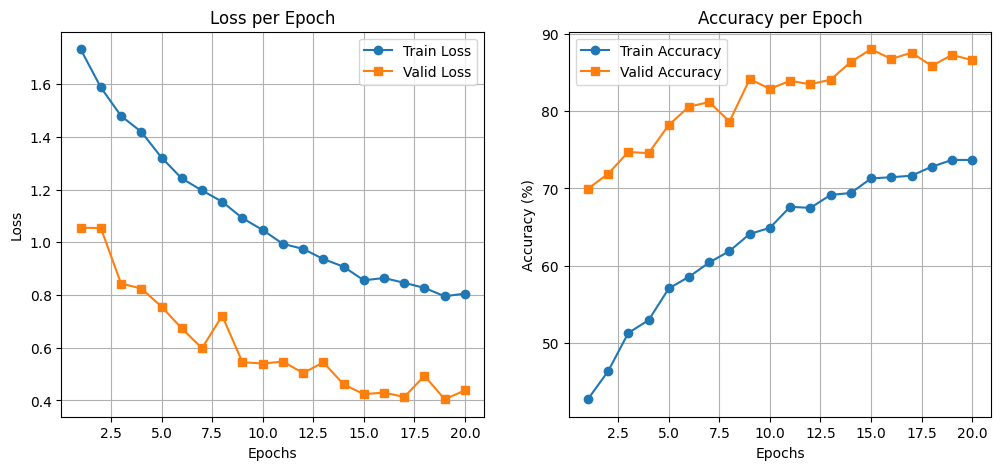

In [9]:
import matplotlib.pyplot as plt

# Dane z treningu
epochs = list(range(1, 21))
train_loss = [1.7331, 1.5880, 1.4798, 1.4195, 1.3220, 1.2427, 1.1972, 1.1542, 1.0920, 1.0470, 
              0.9944, 0.9753, 0.9368, 0.9077, 0.8561, 0.8646, 0.8466, 0.8271, 0.7956, 0.8054]
valid_loss = [1.0557, 1.0542, 0.8438, 0.8247, 0.7562, 0.6735, 0.5984, 0.7213, 0.5453, 0.5402, 
              0.5478, 0.5040, 0.5447, 0.4613, 0.4239, 0.4298, 0.4133, 0.4934, 0.4047, 0.4380]

train_acc = [42.70, 46.33, 51.29, 52.93, 57.05, 58.56, 60.41, 61.89, 64.10, 64.90, 
             67.62, 67.48, 69.16, 69.41, 71.30, 71.45, 71.65, 72.81, 73.69, 73.69]
valid_acc = [69.96, 71.90, 74.72, 74.57, 78.22, 80.59, 81.19, 78.66, 84.16, 82.90, 
             83.94, 83.49, 84.09, 86.39, 88.03, 86.77, 87.58, 85.87, 87.29, 86.62]

# Wykres strat
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Train Loss', marker='o')
plt.plot(epochs, valid_loss, label='Valid Loss', marker='s')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss per Epoch')
plt.legend()
plt.grid()

# Wykres dokładności
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, label='Train Accuracy', marker='o')
plt.plot(epochs, valid_acc, label='Valid Accuracy', marker='s')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy per Epoch')
plt.legend()
plt.grid()

plt.show()


In [36]:
torch.save(model.state_dict(), "best_model.pth")
print("✅ Model zapisany jako 'best_model.pth'")


✅ Model zapisany jako 'best_model.pth'


✅ Pozytywne aspekty:
✔ Stały spadek loss – zarówno dla train, jak i valid (czyli model się uczy).
✔ Rośnie accuracy – model poprawia swoje przewidywania.
✔ Brak drastycznego overfittingu – różnica między train acc i valid acc nie jest ogromna.

❌ Potencjalne problemy:
Lekki overfitting

Train Accuracy: 73.69%
Valid Accuracy: 86.62%
Model osiąga lepszą dokładność na walidacji niż na treningu, co jest nietypowe (może wynikać z dropoutu lub augmentacji danych).
Jeśli na testowym accuracy spada np. do 30%, to problem może być większy (dane treningowe i testowe mogą się różnić).
Valid Loss nieco niestabilny

Po 17-20 epoce valid loss rośnie, np.
Ep. 17: 0.4133
Ep. 18: 0.4934 ⬆ (zwiększa się!)
Ep. 19: 0.4047 ⬇ (spada)
Ep. 20: 0.4380 ⬆ (znowu rośnie)
Może sugerować fluktuacje lub problem z generalizacją. Może warto zatrzymać trenowanie wcześniej (early stopping?).
Czy loss i accuracy są spójne?

Jeśli accuracy rośnie, ale valid loss przestaje spadać lub rośnie, może oznaczać przeuczenie (overfitting) lub problem z regularizacją.

In [11]:
num_epochs = 20  # Możesz zmienić na 10-20
learning_rate = 0.01  # Najlepszy znaleziony LR
weight_decay = 1e-5   # Najlepszy znaleziony weight decay
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [13]:
import torch
from torchvision import models

# Wczytanie modelu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Tworzymy instancję modelu
num_classes = 52  # Upewnij się, że liczba klas się zgadza
model = FineTunedResNet(num_classes=num_classes)
model.load_state_dict(torch.load("best_model.pth", map_location=device))  # Wczytanie wag
model.to(device)
model.eval()  # Przełączenie na tryb ewaluacji

# Definicja funkcji straty
criterion = torch.nn.CrossEntropyLoss()

test_loss = 0.0
correct = 0
total = 0

# Ewaluacja modelu
with torch.no_grad():  
    for inputs, labels in test_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)  
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        test_loss += loss.item()
        
        _, predicted = torch.max(outputs, 1)  
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

# Oblicz średni loss i dokładność
test_loss /= len(test_dataloader)
test_accuracy = 100 * correct / total

print(f"📊 Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")


C:\Users\48517\AppData\Local\Temp\ipykernel_66980\427241504.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth", map_locat

📊 Test Loss: 0.4311, Test Accuracy: 86.15%


In [10]:
card_order = [
    "AC", "AD", "AH", "AS",  # Asy
    "8C", "8D", "8H", "8S",  # Ósemki
    "5C", "5D", "5H", "5S",  # Piątki
    "4C", "4D", "4H", "4S",  # Czwórki
    "JC", "JD", "JH", "JS",  # Walety
    "KC", "KD", "KH", "KS",  # Króle
    "9C", "9D", "9H", "9S",  # Dziewiątki
    "QC", "QD", "QH", "QS",  # Damy
    "7C", "7D", "7H", "7S",  # Siódemki
    "6C", "6D", "6H", "6S",  # Szóstki
    "10C", "10D", "10H", "10S",  # Dziesiątki
    "3C", "3D", "3H", "3S",  # Trójki
    "2C", "2D", "2H", "2S"   # Dwójki
]


C:\Users\48517\AppData\Local\Temp\ipykernel_66980\1034190161.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth", map_locat

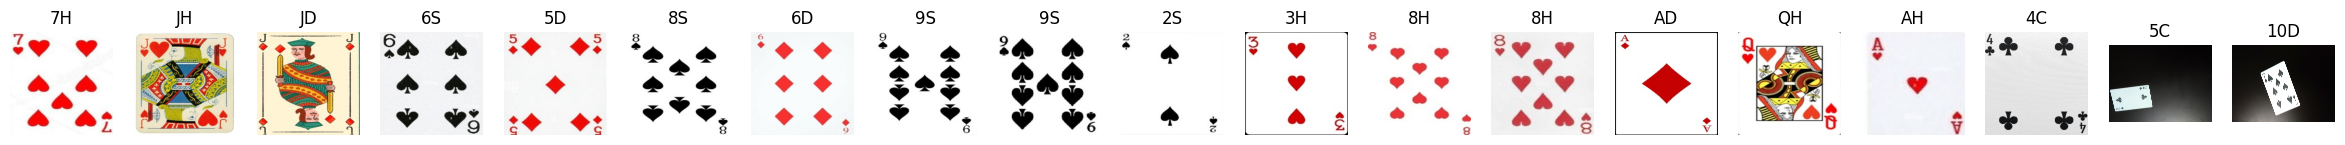

In [22]:
import os
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

num_classes = 52  # Upewnij się, że liczba klas się zgadza
model = FineTunedResNet(num_classes=num_classes)
model.load_state_dict(torch.load("best_model.pth", map_location=device))  # Wczytanie wag
model.to(device)
model.eval()  # Przełączenie na tryb ewaluacji


# Ścieżka do folderu z obrazami
folder_path = r"C:\Users\48517\Desktop\Kurs CV\Projekt\karty\los"

# Transformacja obrazu (dostosuj do modelu)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Dopasuj do wymagań modelu
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  
])


# Funkcja do wczytania i przetworzenia obrazu
def preprocess_image(image_path):
    image = Image.open(image_path).convert("RGB")  # Wczytanie i konwersja do RGB
    return transform(image).unsqueeze(0)  # Dodanie wymiaru batch

# Przetwarzanie wszystkich obrazów w folderze
image_files = [f for f in os.listdir(folder_path) if f.endswith((".png", ".jpg", ".jpeg"))]

# Ustawienie modelu w tryb ewaluacji
model.eval()

# Tworzenie wykresu
fig, axes = plt.subplots(nrows=1, ncols=len(image_files), figsize=(30, 15))

for i, file_name in enumerate(image_files):
    image_path = os.path.join(folder_path, file_name)
    image = preprocess_image(image_path)

    # Predykcja
    with torch.no_grad():
        output = model(image)
        predicted_class = torch.argmax(output, dim=1).item()

    # Mapowanie wyniku na nazwę karty
    predicted_card = card_order[predicted_class]

    # Wyświetlanie obrazu z predykcją
    img = Image.open(image_path)
    axes[i].imshow(img)
    axes[i].axis("off")
    axes[i].set_title(predicted_card)

plt.show()
